In [1]:
import os
import numpy as np
from skimage import io, color
from scipy.stats import kurtosis, skew, entropy
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from PIL import Image
import math

In [2]:
def get_media(imagem):
    largura, altura = imagem.size
    soma_pixel = 0
    pixels = imagem.load()

    if imagem.mode == 'RGB':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                soma_pixel += sum(pixel)
    elif imagem.mode == 'L':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                soma_pixel += pixel  # Imagem em tons de cinza tem apenas um valor de pixel

    media = soma_pixel / (largura * altura)

    return media


def get_variancia(imagem):
    largura, altura = imagem.size
    soma_pixel = 0
    soma_quadrados = 0
    pixels = imagem.load()
    
    if imagem.mode == 'RGB':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                soma_pixel += sum(pixel)
                soma_quadrados += sum(componente ** 2 for componente in pixel)
    elif imagem.mode == 'L':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                soma_pixel += pixel
                soma_quadrados += pixel ** 2

    media = soma_pixel / (largura * altura)
    variancia = (soma_quadrados / (largura * altura)) - (media ** 2)
    
    return variancia


def get_skewness(imagem):
    largura, altura = imagem.size
    soma_pixel = 0
    soma_quadrados = 0
    soma_cubo = 0
    pixels = imagem.load()

    if imagem.mode == 'RGB':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                soma_pixel += sum(pixel)
                soma_quadrados += sum(componente ** 2 for componente in pixel)
                soma_cubo += sum(componente ** 3 for componente in pixel)
    elif imagem.mode == 'L':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                soma_pixel += pixel
                soma_quadrados += pixel ** 2
                soma_cubo += pixel ** 3

    media = soma_pixel / (largura * altura)

    variancia = (soma_quadrados / (largura * altura)) - (media ** 2)

    skewness = (soma_cubo / (largura * altura)) - 3 * media * variancia - media ** 3

    return skewness


def get_kurtosis(imagem):

    largura, altura = imagem.size
    soma_pixel = 0
    soma_quadrados = 0
    soma_quarta_potencia = 0
    pixels = imagem.load()

    if imagem.mode == 'RGB':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                soma_pixel += sum(pixel)
                soma_quadrados += sum(componente ** 2 for componente in pixel)
                soma_quarta_potencia += sum(componente ** 4 for componente in pixel)
    elif imagem.mode == 'L':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                soma_pixel += pixel
                soma_quadrados += pixel ** 2
                soma_quarta_potencia += pixel ** 4
            
    media = soma_pixel / (largura * altura)

    variancia = (soma_quadrados / (largura * altura)) - (media ** 2)

    kurtosis = (soma_quarta_potencia / (largura * altura)) - 3 * (variancia ** 2)

    return kurtosis


def get_energia(imagem):
    largura, altura = imagem.size
    soma_quadrados = 0
    pixels = imagem.load()

    if imagem.mode == 'RGB':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                for componente in pixel:
                    soma_quadrados += componente ** 2
    elif imagem.mode == 'L':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                soma_quadrados += pixel ** 2

    energia = soma_quadrados

    return energia


def get_entropia(imagem):
    largura, altura = imagem.size
    frequencia_pixel = {}

    pixels = imagem.load()

    if imagem.mode == 'RGB':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                frequencia_pixel[pixel] = frequencia_pixel.get(pixel, 0) + 1
    elif imagem.mode == 'L':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                frequencia_pixel[pixel] = frequencia_pixel.get(pixel, 0) + 1

    entropia = 0.0
    total_pixels = largura * altura

    for valor_pixel, frequencia in frequencia_pixel.items():
        probabilidade = frequencia / total_pixels
        entropia -= probabilidade * math.log2(probabilidade)

    return entropia


def descritor_histograma(imagem):
    
    media = get_media(imagem)
    var = get_variancia(imagem)
    sk = get_skewness(imagem)
    kur = get_kurtosis(imagem)
    ener = get_energia(imagem)
    entr = get_entropia(imagem)

    return [media,var,sk,kur,ener,entr]


In [12]:
def alargamento_contraste(imagem, k):
    largura, altura = imagem.size
    pixels = imagem.load()

    if imagem.mode == 'RGB':
        for x in range(largura):
            for y in range(altura):
                pixel = list(pixels[x, y])  # Transforme a tupla (pixel) em uma lista
                r = pixel[0] / 255.0  # Normalizar o valor do pixel para o intervalo [0, 1]
                # Aplicar a fórmula do alargamento de contraste
                r_transformado = 1 / (1 + k / (r + 1e-5))
                pixel[0] = int(r_transformado * 255)  # Desfazer a normalização
                pixels[x, y] = tuple(pixel)  # Atualizar o pixel na imagem
    elif imagem.mode == 'L':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                r = pixel / 255.0  # Normalizar o valor do pixel para o intervalo [0, 1]
                r_transformado = 1 / (1 + k / (r + 1e-5))
                pixels[x, y] = int(r_transformado * 255)  # Atualizar o pixel na imagem

    return imagem

def negativo(imagem):
    largura, altura = imagem.size
    pixels = imagem.load()

    if imagem.mode == 'RGB':
        for x in range(largura):
            for y in range(altura):
                pixel = list(pixels[x, y])
                for i in range(len(pixel)):
                    pixel[i] = 255 - pixel[i]
                pixels[x, y] = tuple(pixel)
    elif imagem.mode == 'L':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                pixels[x, y] = 255 - pixel

    return imagem

def logaritmo(imagem, c):
    largura, altura = imagem.size
    pixels = imagem.load()

    if imagem.mode == 'RGB':
        for x in range(largura):
            for y in range(altura):
                pixel = list(pixels[x, y])
                for i in range(len(pixel)):
                    r = pixel[i] / 255.0
                    r_transformado = c * math.log(1 + r)
                    pixel[i] = int(r_transformado * 255)
                pixels[x, y] = tuple(pixel)
    elif imagem.mode == 'L':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                r = pixel / 255.0
                r_transformado = c * math.log(1 + r)
                pixels[x, y] = int(r_transformado * 255)

    return imagem

def potencia(imagem, c, gamma):
    largura, altura = imagem.size
    pixels = imagem.load()

    if imagem.mode == 'RGB':
        for x in range(largura):
            for y in range(altura):
                pixel = list(pixels[x, y])
                for i in range(len(pixel)):
                    r = pixel[i] / 255.0
                    r_transformado = c * (r ** gamma)
                    pixel[i] = int(r_transformado * 255)
                pixels[x, y] = tuple(pixel)
    elif imagem.mode == 'L':
        for x in range(largura):
            for y in range(altura):
                pixel = pixels[x, y]
                r = pixel / 255.0
                r_transformado = c * (r ** gamma)
                pixels[x, y] = int(r_transformado * 255)

    return imagem


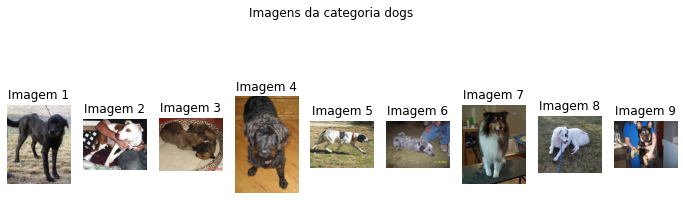

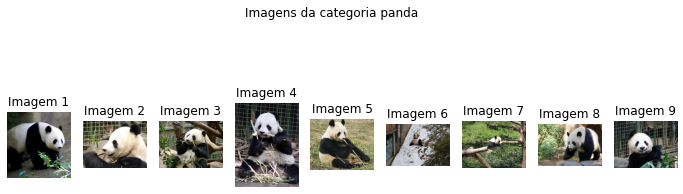

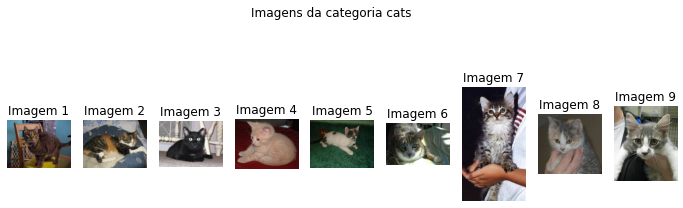

In [4]:
# Diretório onde as imagens estão armazenadas
dataset_path = os.path.join(os.getcwd(), 'datasets', 'animals')

# Categorias de animais
categorias = ['dogs', 'panda', 'cats']

# 2. Aplicar as transformações de intensidade e extrair atributos
transformacoes = ["alargamento", "negativo", "logaritmo", "potencia"]

# Número de imagens a serem exibidas por categoria
num_images_to_display = 9

# Loop para percorrer as categorias e exibir algumas imagens de cada categoria
for categoria in categorias:
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 4))
    fig.suptitle(f'Imagens da categoria {categoria}')
    
    # Diretório da categoria
    diretorio_categoria = os.path.join(dataset_path, categoria)
    imagens_categoria = os.listdir(diretorio_categoria)
    
    for i in range(num_images_to_display):
        # Carregar a imagem
        imagem = io.imread(os.path.join(diretorio_categoria, imagens_categoria[i]))
        axes[i].imshow(imagem)
        axes[i].set_title(f'Imagem {i+1}')
        axes[i].axis('off')
    
    plt.show()

In [5]:
# Lista para armazenar os atributos e rótulos
atributos = []
rotulos = []

# Loop para percorrer as categorias
for categoria in categorias:
    diretorio_categoria = os.path.join(dataset_path, categoria)
    for nome_arquivo in os.listdir(diretorio_categoria):
        # Caminho completo da imagem
        caminho_imagem = os.path.join(diretorio_categoria, nome_arquivo)
        # Carregar a imagem
        imagem = Image.open(caminho_imagem)
        
        print(imagem)
        
        # Calcular os atributos de textura
        atributos_textura = descritor_histograma(imagem)
        # Adicionar os atributos à lista
        atributos.append(atributos_textura)
        # Adicionar o rótulo de classe (0 para dogs, 1 para panda, 2 para cats)
        rotulos.append(categorias.index(categoria))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=382x478 at 0x2141AD63E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=321x260 at 0x214194216D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x271 at 0x2141ABF9BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=327x499 at 0x2141AA830D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x260 at 0x2141AA83040>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x374 at 0x2141AA83130>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x400 at 0x2141AA83040>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x447 at 0x2141AA837F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x374 at 0x2141AA830A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x375 at 0x2141AA832B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=299x264 at 0x2141AA830D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=237x303 at 0x2141AA837C0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=422x500 at 0x214199D2D90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=301x342 at 0x214199D2370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x392 at 0x214199D2E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=391x500 at 0x214199D2E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x331 at 0x214199D2F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=436x400 at 0x214199D2E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=266x371 at 0x214199D2130>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x333 at 0x214199D2BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=188x270 at 0x214199D2130>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=141x93 at 0x214199D2B20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=296x399 at 0x214199D2130>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=399x462 at 0x214199D2E80>
<PIL.JpegImagePlugin.JpegImag

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=373x500 at 0x2141AA6B9A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x375 at 0x2141AA6BFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x375 at 0x2141AA6BA00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=275x237 at 0x2141AA6BFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=440x500 at 0x2141AA6BB20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=405x320 at 0x2141AA6BFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x358 at 0x2141AA6BCD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=305x204 at 0x2141AA6BFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x375 at 0x2141AA6BCD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=394x370 at 0x2141AA6BD60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=399x400 at 0x2141AA6BE20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=398x500 at 0x2141AA6B2E0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141998B5E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x2141998B580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141998B220>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141998B580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=594x402 at 0x2141998B310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=454x500 at 0x2141998BA30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141998B7F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141998B760>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=783x500 at 0x2141AA5EEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x2141AA5ECA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141AA5EEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141AA5ECA0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=468x500 at 0x21419955D00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x355 at 0x214199553A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=113x170 at 0x21419955CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x214199553A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x419 at 0x21419955A60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x21419955D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x21419955CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x21419955A30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x21419955C10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x334 at 0x21419955A60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x21419955AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x21419955DC0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x2141AA525E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141AA52730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x334 at 0x2141AA52BB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141AA529A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x332 at 0x2141AA52070>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141AA529A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x326 at 0x2141AA52190>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x442 at 0x2141AA522E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x387 at 0x2141993EA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141993EE20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141993EA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x2141993ECD0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x374 at 0x2141988A6D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x359 at 0x2141988A730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x440 at 0x2141988A760>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x313 at 0x2141988A550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=321x499 at 0x2141988A6D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=299x225 at 0x2141988A550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x374 at 0x2141988A910>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=261x499 at 0x2141988A550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=378x500 at 0x2141988ACD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x2141988A670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x375 at 0x2141988ACD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x225 at 0x2141988ABB0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=387x499 at 0x214198764C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x374 at 0x21419876280>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=359x270 at 0x21419876EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=196x215 at 0x21419876DF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=359x500 at 0x214198765E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=215x323 at 0x21419876C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x376 at 0x21419876EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=336x426 at 0x21419876C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x259 at 0x21419876D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=299x184 at 0x21419876B50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=414x319 at 0x21419876CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x374 at 0x21419876AF0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=376x499 at 0x2141983CA30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=431x499 at 0x2141983C340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x332 at 0x2141983CA30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x375 at 0x2141983C340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=477x444 at 0x2141983CEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=398x400 at 0x2141983C430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x335 at 0x2141983CF40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x375 at 0x2141983C520>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x390 at 0x2141983CF70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x298 at 0x2141983CE20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x375 at 0x2141983CCD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=172x269 at 0x2141983CAF0>
<PIL.JpegImagePlugin.JpegIma

In [6]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(atributos, rotulos, test_size=0.3, random_state=42)

# Criar um classificador MLP (rede neural)
clf = MLPClassifier()
clf.fit(X_train, y_train)  # Treinar o classificador

# Realizar a predição no conjunto de teste
y_pred = clf.predict(X_test)

# Calcular a acurácia
acuracia = accuracy_score(y_test, y_pred)

# Exibir a acurácia
print(f'Acurácia da classificação: {acuracia:.2f}')

Acurácia da classificação: 0.50


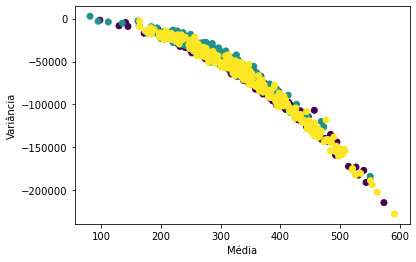

In [7]:
# Scatter plot dos atributos (apenas um exemplo)
plt.scatter([x[0] for x in atributos], [x[1] for x in atributos], c=rotulos, cmap='viridis')
plt.xlabel('Média')
plt.ylabel('Variância')
plt.show()

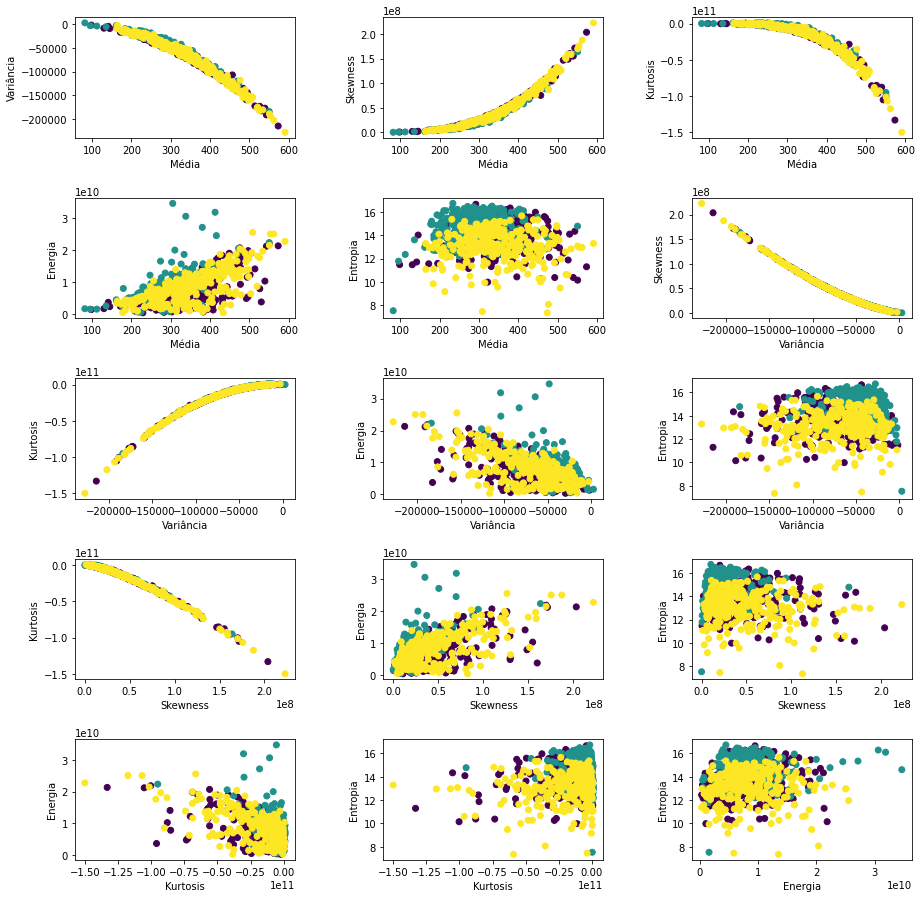

In [8]:
from itertools import combinations

# Scatter plots dos atributos (combinando todos os pares)
atributos = np.array(atributos)
atributos_nomes = ["Média", "Variância", "Skewness", "Kurtosis", "Energia", "Entropia"]

# Criar um layout de subplots
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
fig.subplots_adjust(wspace=0.4, hspace=0.4)  # Espaçamento entre os subplots

# Combinações de pares de atributos
combinations = list(combinations(range(6), 2))

for i, (attr1, attr2) in enumerate(combinations):
    row = i // 3  # Linha atual
    col = i % 3   # Coluna atual
    ax = axes[row, col]  # Seleciona o subplot atual
    ax.scatter(atributos[:, attr1], atributos[:, attr2], c=rotulos, cmap='viridis')
    ax.set_xlabel(atributos_nomes[attr1])
    ax.set_ylabel(atributos_nomes[attr2])

    # Quando chegarmos ao terceiro subplot em uma linha, avance para a próxima linha
    if col == 2:
        plt.subplots_adjust(bottom=0.1)  # Ajuste a parte inferior do gráfico para acomodar nomes de atributos
        fig.subplots_adjust(hspace=0.5)  # Aumente o espaçamento vertical

# Remove subplots vazios (caso haja)
for i in range(len(combinations), 5 * 3):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.axis('off')

plt.show()


In [13]:
atributos_transformacoes = {}
k = 1.0  # Valor de k para o alargamento de contraste
c = 1.0  # Valor de c para a transformação logarítmica
gamma = 1.0  # Valor de gamma para a transformação de potência
for transformacao in transformacoes:
    atributos_transformacoes[transformacao] = []  # Inicializar lista de atributos
    for categoria in categorias:
        diretorio_categoria = os.path.join(dataset_path, categoria)
        for i, nome_arquivo in enumerate(os.listdir(diretorio_categoria)):
            caminho_imagem = os.path.join(diretorio_categoria, nome_arquivo)
            imagem = Image.open(caminho_imagem)

            # Aplicar a transformação de intensidade
            if transformacao == "alargamento":
                imagem_transformada = alargamento_contraste(imagem, k)
            elif transformacao == "negativo":
                imagem_transformada = negativo(imagem)
            elif transformacao == "logaritmo":
                imagem_transformada = logaritmo(imagem, c)
            elif transformacao == "potencia":
                imagem_transformada = potencia(imagem, c, gamma)

            # Calcular atributos de textura após a transformação
            atributos_textura = descritor_histograma(imagem_transformada)
            atributos_transformacoes[transformacao].append(atributos_textura)

            # Imprimir o progresso a cada N imagens (por exemplo, a cada 10)
            if (i + 1) % 10 == 0:
                print(f'Processadas {i + 1} imagens de {len(os.listdir(diretorio_categoria))}')

# Agora, no final do processamento, você pode imprimir que o processamento foi concluído
print('Processamento de imagens concluído.')


Processadas 10 imagens de 300
Processadas 20 imagens de 300
Processadas 30 imagens de 300
Processadas 40 imagens de 300
Processadas 50 imagens de 300
Processadas 60 imagens de 300
Processadas 70 imagens de 300
Processadas 80 imagens de 300
Processadas 90 imagens de 300
Processadas 100 imagens de 300
Processadas 110 imagens de 300
Processadas 120 imagens de 300
Processadas 130 imagens de 300
Processadas 140 imagens de 300
Processadas 150 imagens de 300
Processadas 160 imagens de 300
Processadas 170 imagens de 300
Processadas 180 imagens de 300
Processadas 190 imagens de 300
Processadas 200 imagens de 300
Processadas 210 imagens de 300
Processadas 220 imagens de 300
Processadas 230 imagens de 300
Processadas 240 imagens de 300
Processadas 250 imagens de 300
Processadas 260 imagens de 300
Processadas 270 imagens de 300
Processadas 280 imagens de 300
Processadas 290 imagens de 300
Processadas 300 imagens de 300
Processadas 10 imagens de 300
Processadas 20 imagens de 300
Processadas 30 imag

Processadas 280 imagens de 300
Processadas 290 imagens de 300
Processadas 300 imagens de 300
Processadas 10 imagens de 300
Processadas 20 imagens de 300
Processadas 30 imagens de 300
Processadas 40 imagens de 300
Processadas 50 imagens de 300
Processadas 60 imagens de 300
Processadas 70 imagens de 300
Processadas 80 imagens de 300
Processadas 90 imagens de 300
Processadas 100 imagens de 300
Processadas 110 imagens de 300
Processadas 120 imagens de 300
Processadas 130 imagens de 300
Processadas 140 imagens de 300
Processadas 150 imagens de 300
Processadas 160 imagens de 300
Processadas 170 imagens de 300
Processadas 180 imagens de 300
Processadas 190 imagens de 300
Processadas 200 imagens de 300
Processadas 210 imagens de 300
Processadas 220 imagens de 300
Processadas 230 imagens de 300
Processadas 240 imagens de 300
Processadas 250 imagens de 300
Processadas 260 imagens de 300
Processadas 270 imagens de 300
Processadas 280 imagens de 300
Processadas 290 imagens de 300
Processadas 300 i

In [14]:
# 3. Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = {}, {}, {}, {}
for transformacao in transformacoes:
    X_train[transformacao], X_test[transformacao], y_train[transformacao], y_test[transformacao] = train_test_split(
        atributos_transformacoes[transformacao], rotulos, test_size=0.3, random_state=42
    )

In [15]:
# 4. Treinar e avaliar classificadores para cada transformação
classificadores = {}
acuracias = {}

In [16]:
for transformacao in transformacoes:
    clf = MLPClassifier()
    clf.fit(X_train[transformacao], y_train[transformacao])
    y_pred = clf.predict(X_test[transformacao])
    acuracia = accuracy_score(y_test[transformacao], y_pred)

    classificadores[transformacao] = clf
    acuracias[transformacao] = acuracia

    print(f'Acurácia da classificação ({transformacao}): {acuracia:.2f}')

Acurácia da classificação (alargamento): 0.48
Acurácia da classificação (negativo): 0.29
Acurácia da classificação (logaritmo): 0.49
Acurácia da classificação (potencia): 0.45


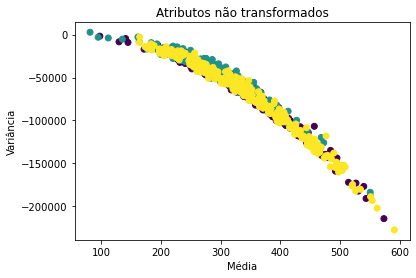

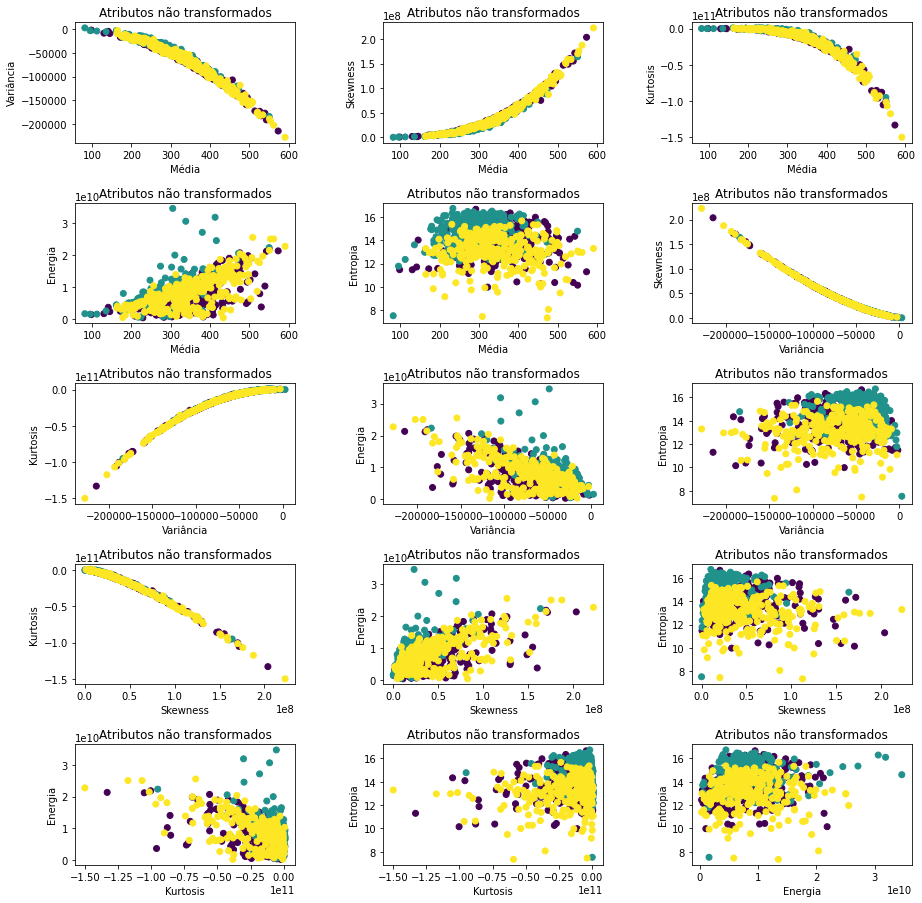

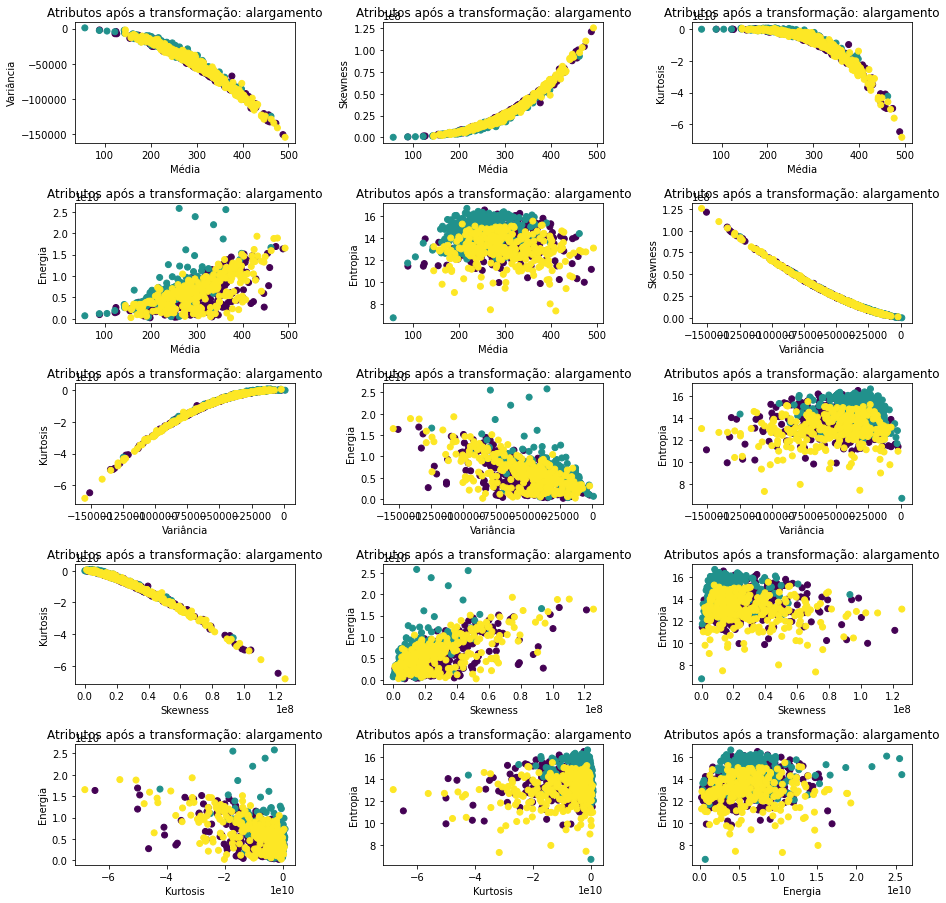

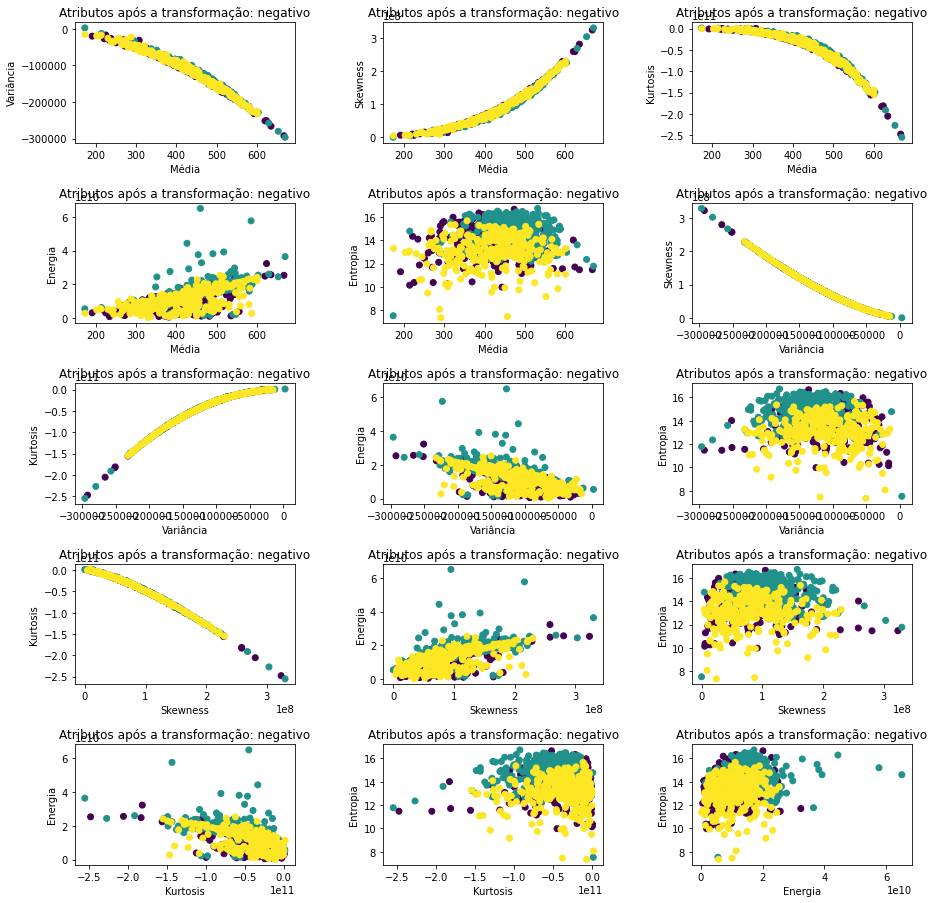

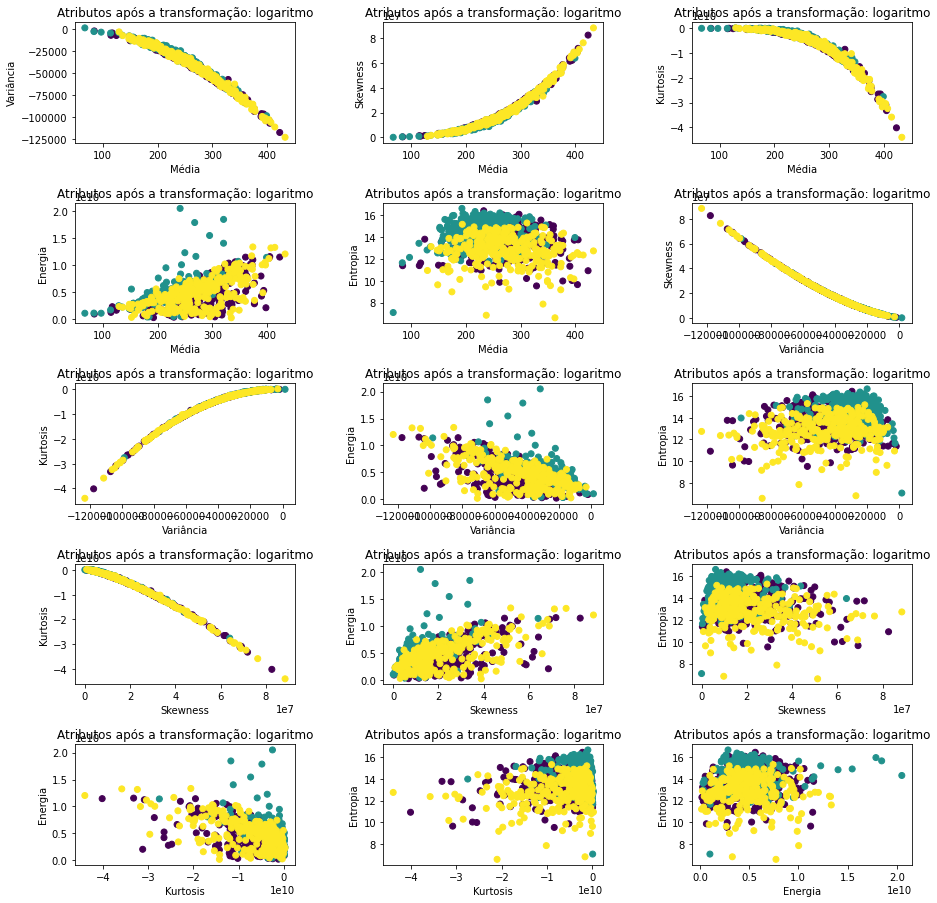

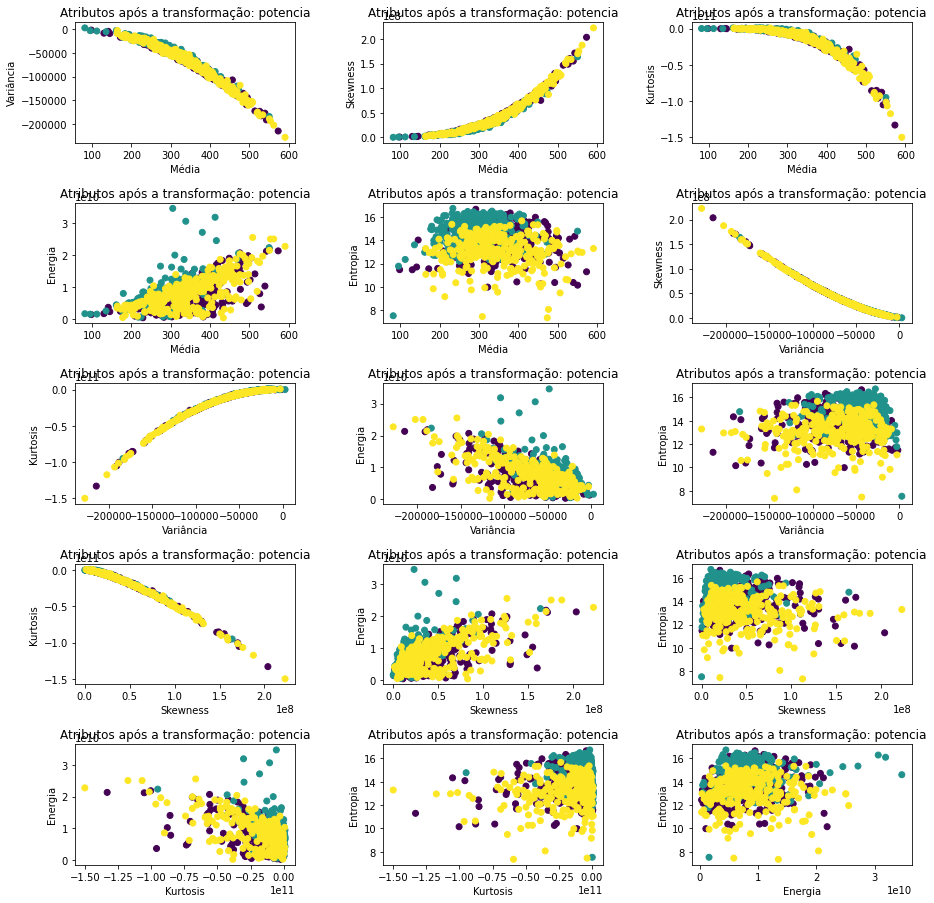

In [17]:
import matplotlib.pyplot as plt

# Scatter plot dos atributos (apenas um exemplo)
plt.scatter([x[0] for x in atributos], [x[1] for x in atributos], c=rotulos, cmap='viridis')
plt.xlabel('Média')
plt.ylabel('Variância')
plt.title('Atributos não transformados')
plt.show()

from itertools import combinations

# Scatter plots dos atributos (combinando todos os pares)
atributos = np.array(atributos)
atributos_nomes = ["Média", "Variância", "Skewness", "Kurtosis", "Energia", "Entropia"]

# Criar um layout de subplots
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
fig.subplots_adjust(wspace=0.4, hspace=0.4)  # Espaçamento entre os subplots

# Combinações de pares de atributos
combinations = list(combinations(range(6), 2))

for i, (attr1, attr2) in enumerate(combinations):
    row = i // 3  # Linha atual
    col = i % 3   # Coluna atual
    ax = axes[row, col]  # Seleciona o subplot atual
    ax.scatter(atributos[:, attr1], atributos[:, attr2], c=rotulos, cmap='viridis')
    ax.set_xlabel(atributos_nomes[attr1])
    ax.set_ylabel(atributos_nomes[attr2])
    ax.set_title('Atributos não transformados')

    # Quando chegarmos ao terceiro subplot em uma linha, avance para a próxima linha
    if col == 2:
        plt.subplots_adjust(bottom=0.1)  # Ajuste a parte inferior do gráfico para acomodar nomes de atributos
        fig.subplots_adjust(hspace=0.5)  # Aumente o espaçamento vertical

# Scatter plots dos atributos após as transformações
for transformacao in transformacoes:
    atributos_transformados = atributos_transformacoes[transformacao]
    
    # Criar um layout de subplots
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)  # Espaçamento entre os subplots

    for i, (attr1, attr2) in enumerate(combinations):
        row = i // 3  # Linha atual
        col = i % 3   # Coluna atual
        ax = axes[row, col]  # Seleciona o subplot atual
        ax.scatter([x[attr1] for x in atributos_transformados], [x[attr2] for x in atributos_transformados], c=rotulos, cmap='viridis')
        ax.set_xlabel(atributos_nomes[attr1])
        ax.set_ylabel(atributos_nomes[attr2])
        ax.set_title(f'Atributos após a transformação: {transformacao}')

        # Quando chegarmos ao terceiro subplot em uma linha, avance para a próxima linha
        if col == 2:
            plt.subplots_adjust(bottom=0.1)  # Ajuste a parte inferior do gráfico para acomodar nomes de atributos
            fig.subplots_adjust(hspace=0.5)  # Aumente o espaçamento vertical

plt.show()
